Modeling and testing grounds

In [14]:
import glob, pylab, pandas as pd
import pydicom, numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, SpatialDropout2D
from keras.utils import to_categorical
from keras.models import load_model

from numpy.random import seed
from tensorflow import set_random_seed

from skimage.transform import resize

import datetime
from tqdm import tqdm_notebook
import pickle

In [3]:
# Initial setting of random seeds
seed(42)
set_random_seed(42)

## Modeling and Evaluation Functions

Writing multiple functions to facilitate creating different datasets, modeling over different datasets and/or different hyperparameters, and evaluating the different models using graphs




In [4]:
class PnemoniaTargetMapIsWeird(AssertionError):
    """Raise this when the target is not mapped to 2 or 3 outputs"""
    pass

In [5]:
def create_pic_df(data, df_detailed, image_size = (128,128)):
    
    print('---Enter DataFrame Construction Function---')
    
    ## Data Prep
    # Need to define df_detailed somewhere
    data.drop_duplicates(inplace=True)
    merged_df = df_detailed.merge(data, on='patientId')
    
    print('---Create Pixel Array Labels---')
    
    # Create the column labels for the pixel arrays
    pixel_labels = []
    for i in range(image_size[0] * image_size[1]):
        pixel_labels.append("pixel"+str(i))
    
    print('---Create Total Pixel Array---')
    
    # Create the total pixel array
    huge_pixel_array = []
    for o in tqdm_notebook(range(merged_df.shape[0])):
        # Get the image data
        patientId = merged_df.iloc[o]['patientId']
        dcm_file = '../data/stage_1_train_images/%s.dcm' % patientId
        dcm_data = pydicom.read_file(dcm_file)
        im = dcm_data.pixel_array

        # Convert the image into a 1d array of pixels
        curr_pixel_array = []
        for i in resize(im, image_size): 
            curr_pixel_array.extend(i)
        huge_pixel_array.append(curr_pixel_array)

    print('---Create Dataframe---')
        
    # Creating the DataFrame
    temp = pd.DataFrame(data = huge_pixel_array, columns = pixel_labels)
    temp['class'] = merged_df['class']
    return temp

In [50]:
def model(data, model_name = "default_model_name", image_size = (128,128), y_map = {
    "Lung Opacity":1,
    "No Lung Opacity / Not Normal":0,
    "Normal":2
}, epochs = 20, train_size = 0.75, metrics = ['accuracy'], batch_size = 10, model_optimizer = 'adam', verbose = 1):
    """
    Args:
        data (Pandas DataFrame): cols=['class', all of the pixel data]
        
        model_name (str): The name with which to save the model
        
        image_size (touple: (int,int)): The width and height in pixels to scale the images. Max 1024x1024. This might be more finickey that I would've thought.
        
        y_map (dict): A dictionary mapping the target values to integers ([0,1] or [0,1,2])
        
        epochs (int): Number of epochs to train the model over
        
        train_size (float): Denotes the percentage of data to use for training as opposed to testing. Between 0. and 1.  
        
        metrics (list): list of strings metric names with which to measure the model's performance
        
        batch_size (int): Number of images to use
        
        model_optimizer (string or optimizer object): Determines which optimizer for the model to use.
        
        verbose (int): Verbose option for model training. (0, 1, 2)
        
        
    Returns:
        Keras Model fit on the data.
        Saves the model to ../data/models/model_name datetime.h5
    """
    print('---Enter Function---')
    
    # Setting the seeds every time I do another model so that I can make sure to have reproducible results
    seed(42)
    set_random_seed(42)

    # Create target
    y = data['class']
    y = y.map(lambda x: y_map[x])
    
    # Train Test Split
    X_train, X_test, y_train, y_test = train_test_split(data.drop(columns='class'), y, 
                                                        stratify=y, random_state=42, train_size = train_size)
    
    # Transform target into arrays of integers
    y_train_c = to_categorical(y_train)
    y_test_c = to_categorical(y_test)
    
    # Reshape the X_train and X_test 
    X_train_re = X_train.values.reshape(X_train.shape[0], image_size[0], image_size[1], 1)
    X_test_re = X_test.values.reshape(X_test.shape[0], image_size[0], image_size[1], 1)
    
    print('---Modeling Initialization---')
    
    ## Modeling
    # Initialize Model
    model_convolutional = Sequential()

    # First Conv / Pool 
    model_convolutional.add(Conv2D(filters = 6,
                                   kernel_size = 3,
                                   activation = 'relu',
                                   input_shape = (image_size[0], image_size[1], 1)
                                  ))
    model_convolutional.add(MaxPooling2D(pool_size=(2,2)))
    
#    model_convolutional.add(SpatialDropout2D(0.5)) #not included

    # Second Conv/ Pool
    model_convolutional.add(Conv2D(filters=16, 
                                   kernel_size=3, 
                                   activation='relu'))
    model_convolutional.add(MaxPooling2D(pool_size=(2,2)))

    # Flatten
    model_convolutional.add(Dropout(0.8)) #dropout
    model_convolutional.add(Flatten())

    # Densely Connected Layers
    model_convolutional.add(Dense(300, activation='relu'))
    model_convolutional.add(Dropout(0.5))
    model_convolutional.add(Dense(100, activation='relu'))
    model_convolutional.add(Dropout(0.5))
    #model_convolutional.add(Dense( 40, activation='relu'))
    
    # Output Layer
    if len(set(y_map.values())) == 3:
        model_convolutional.add(Dense(3, activation='softmax'))
    elif len(set(y_map.values())) == 2:
        model_convolutional.add(Dense(2, activation='softmax'))
    else:
        raise PnemoniaTargetMapIsWeird("target is not mapped to 2 or 3 outputs")


    model_convolutional.compile(loss = 'categorical_crossentropy', 
                            optimizer = model_optimizer, #'sgd', #adam
                            metrics = metrics)
    
    print('---Modeling Training---')
    
    # Train Model
    trained_convolutional = model_convolutional.fit(X_train_re,
                        y_train_c,
                        batch_size = batch_size,
                        epochs = epochs,
                        verbose = verbose,
                        validation_data = (X_test_re, y_test_c)
                       )


    file_name = '../data/models/' + model_name + ' ' + str(datetime.datetime.now()) 

    # Save Model        
    try:
        model_file_name = file_name + '_model.h5'
        model_convolutional.save(model_file_name)
        print('Model saved as: ' + model_file_name)
        
    except Exception as e:
        print('+++++Model did not save++++++')
        print(e)
        
    # Save History
    try:
        history_file_name = file_name + '_history.pk'
        pickle_file = open(history_file_name, 'wb')
        pickle.dump(trained_convolutional, pickle_file) 
        pickle_file.close()
        print('History saved as: ' + history_file_name)
        
    except Exception as e:
        print('+++++History did not save++++++')
        print(e)
        
        
    return trained_convolutional, model_convolutional, file_name[15:], model_file_name, history_file_name



In [8]:
# Function that displays pertinant information regarding the quality of the model

def evaluate_model (model, model_name = 'default', size=6):
    
    """
    Args:
        model: A trained model with 
        
    Output:
        Returns nothing. Prints out - plots comparing test set with training set on 
        each of the metrics (minimum: loss).
    
    """
    
    # checking out the different classes in the testing case and predictions
    
    # confusion matrix?
    
    keys=[]
    for i in model.history.keys():
        if i[0:3] != 'val':
            keys.append(i)
    
    fig, ax = plt.subplots(len(keys), 1, figsize = (size, size*len(keys))) 
    fig.suptitle('Model: ' + model_name, fontsize=16)
    
    index = 0
    for i in keys:
        # Plot of the Loss for the train and testingsets
        ax[index].plot(model.history[i], label=i.capitalize())
        ax[index].plot(model.history['val_'+i], label='Val '+i.capitalize())
        ax[index].legend()
        ax[index].set_title(i.capitalize())
        index+=1


## Initial Variables

In [11]:
# Lung Opacity == Pneumonia
y_map_3 = { # Normal, Pneumonia, or not normal but not pneumonia
    "Lung Opacity":1,
    "No Lung Opacity / Not Normal":0,
    "Normal":2
}

y_map_2 = { # Either Pneumonia or Not Pneumonia
    "Lung Opacity":1,
    "No Lung Opacity / Not Normal":0,
    "Normal":0
}

adult_data = pd.read_csv('../data/adult_patient_data.csv')
df_detailed = pd.read_csv('../data/stage_1_detailed_class_info.csv')


In [10]:
models = {}

## Some Initial Modeling

In [9]:
# Current Parameters
options = 3


NUM_IMAGES = 6000 #pic_df.shape[0]
EPOCHS = 20
IMAGE_SIZE = (128,128)
TRAIN_SIZE = 0.8
METRICS = ['accuracy']

if options == 2:
    CURR_MAP = y_map_2
    model_name = 'adult_data_2_options'
elif options == 3:
    CURR_MAP = y_map_3
    model_name = 'adult_data_3_options'
else:
    raise PnemoniaTargetMapIsWeird('Set "option" to 2 or 3')


In [10]:
%%time

pic_df = create_pic_df(adult_data, df_detailed=df_detailed, image_size=IMAGE_SIZE)

---Enter DataFrame Construction Function---
---Create Pixel Array Labels---
---Create Total Pixel Array---


FileNotFoundError: [Errno 2] No such file or directory: '../data/stage_1_train_images/0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm'

In [36]:
%%time



test_model_history, test_model_real, most_recent_model_name = model(pic_df.head(NUM_IMAGES), model_name = model_name, image_size=IMAGE_SIZE, y_map=CURR_MAP, EPOCHS=EPOCHS, train_size = TRAIN_SIZE, metrics = METRICS)



---Enter Function---


/home/ec2-user/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


---Modeling---
Train on 4800 samples, validate on 1200 samples
Epoch 1/20
4800/4800 [==============================] - 27s 6ms/step - loss: 0.9727 - acc: 0.5121 - val_loss: 0.8885 - val_acc: 0.5925
Epoch 2/20
4800/4800 [==============================] - 26s 5ms/step - loss: 0.8916 - acc: 0.5648 - val_loss: 0.8520 - val_acc: 0.6017
Epoch 3/20
4800/4800 [==============================] - 26s 5ms/step - loss: 0.8686 - acc: 0.5823 - val_loss: 0.8462 - val_acc: 0.5975
Epoch 4/20
4800/4800 [==============================] - 26s 5ms/step - loss: 0.8549 - acc: 0.5958 - val_loss: 0.8598 - val_acc: 0.6042
Epoch 5/20
4800/4800 [==============================] - 26s 5ms/step - loss: 0.8401 - acc: 0.6002 - val_loss: 0.8355 - val_acc: 0.6183
Epoch 6/20
4800/4800 [==============================] - 26s 5ms/step - loss: 0.8034 - acc: 0.6202 - val_loss: 0.8302 - val_acc: 0.6108
Epoch 7/20
4800/4800 [==============================] - 26s 5ms/step - loss: 0.8031 - acc: 0.6227 - val_loss: 0.8121 - val_acc:

In [91]:
models[most_recent_model_name] = {
    'NUM_IMAGES':NUM_IMAGES,
    'history':test_model_history,
    'EPOCHS':EPOCHS,
    'IMAGE_SIZE':IMAGE_SIZE,
    'Y_MAP':CURR_MAP,
    'TRAIN_SIZE':TRAIN_SIZE,
    'accuracy_scores':{
        'train':test_model_history.history['acc'][-1],
        'test':test_model_history.history['val_acc'][-1]
    }
}

# Save the list of models and parameters 
model_pickle_file_name = 'models.pk'
file_object = open(model_pickle_file_name,'wb')
pickle.dump(models, file_object)
file_object.close()


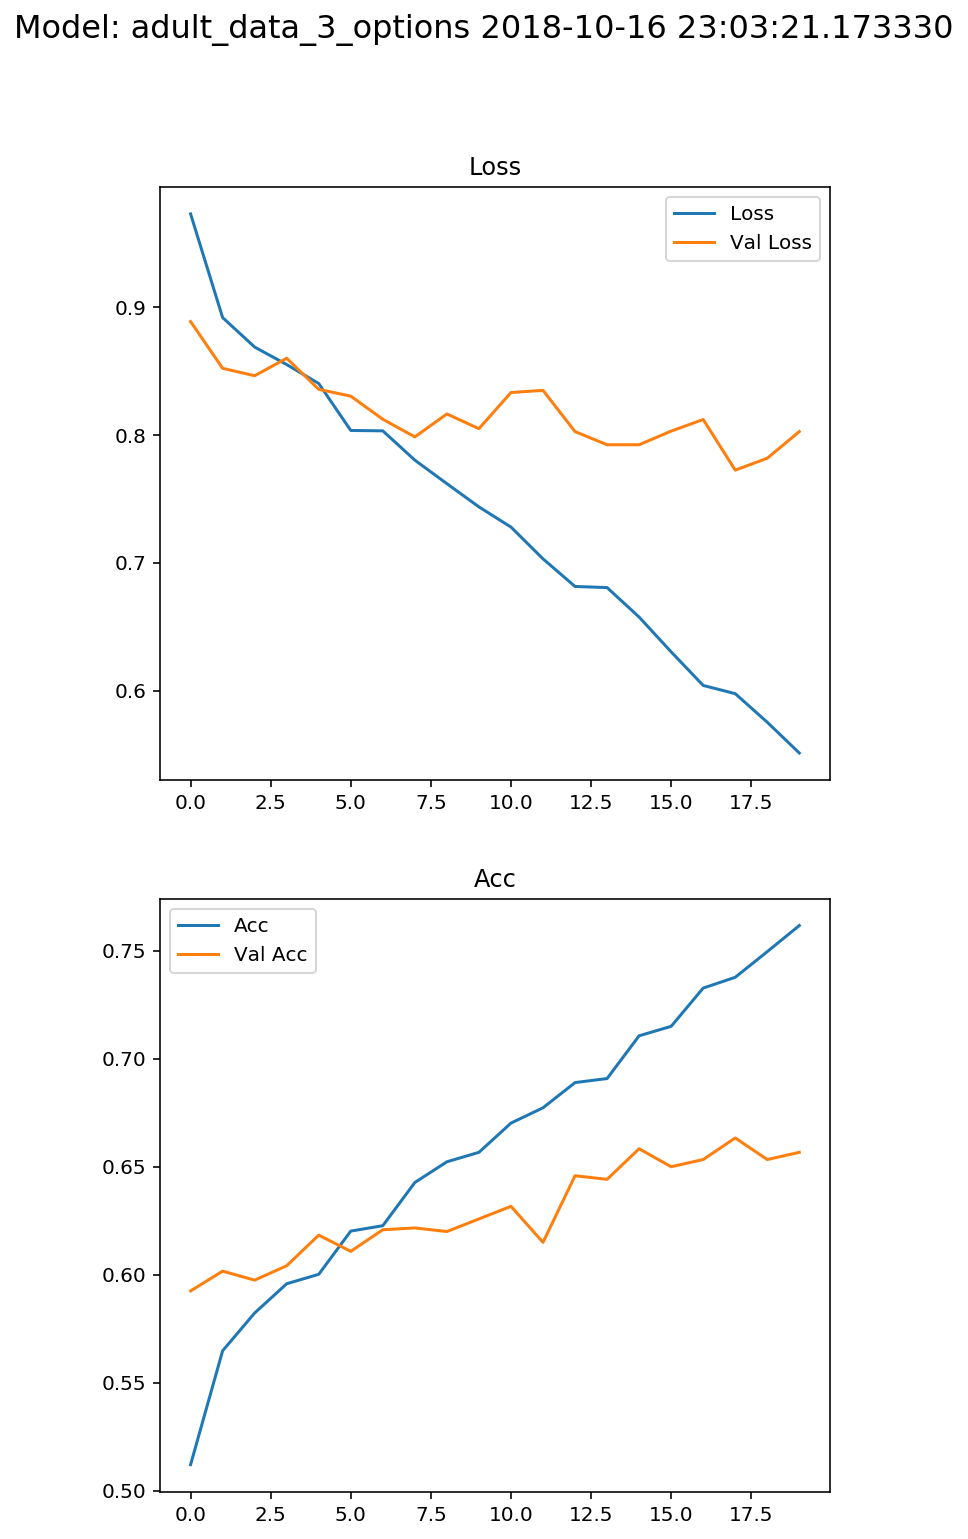

In [73]:
graph_size = 6
evaluate_model(test_model_history, most_recent_model_name, size=graph_size)


In [78]:
# This shows the different levels in my NN
test_model_history.model.get_config()

{'name': 'sequential_2',
 'layers': [{'class_name': 'Conv2D',
   'config': {'name': 'conv2d_3',
    'trainable': True,
    'batch_input_shape': (None, 128, 128, 1),
    'dtype': 'float32',
    'filters': 6,
    'kernel_size': (3, 3),
    'strides': (1, 1),
    'padding': 'valid',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'VarianceScaling',
     'config': {'scale': 1.0,
      'mode': 'fan_avg',
      'distribution': 'uniform',
      'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None}},
  {'class_name': 'MaxPooling2D',
   'config': {'name': 'max_pooling2d_3',
    'trainable': True,
    'pool_size': (2, 2),
    'padding': 'valid',
    'strides': (2, 2),
    'data_format': 'channels_last'}},
  {'clas

In [82]:
models[most_recent_model_name]['history'].model.predict(pic_df.drop(columns='class').iloc[1,:].values)

{'name': 'sequential_2',
 'layers': [{'class_name': 'Conv2D',
   'config': {'name': 'conv2d_3',
    'trainable': True,
    'batch_input_shape': (None, 128, 128, 1),
    'dtype': 'float32',
    'filters': 6,
    'kernel_size': (3, 3),
    'strides': (1, 1),
    'padding': 'valid',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'VarianceScaling',
     'config': {'scale': 1.0,
      'mode': 'fan_avg',
      'distribution': 'uniform',
      'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None}},
  {'class_name': 'MaxPooling2D',
   'config': {'name': 'max_pooling2d_3',
    'trainable': True,
    'pool_size': (2, 2),
    'padding': 'valid',
    'strides': (2, 2),
    'data_format': 'channels_last'}},
  {'clas

## Predicting
Creating predictions and getting useful, interpretable results from the models.

In [42]:
%%time

# Predicting on the images
X = pic_df.drop(columns='class')
pred_x = X.values.reshape(X.shape[0], IMAGE_SIZE[0], IMAGE_SIZE[1], 1)
preds = test_model_real.predict(pred_x)

CPU times: user 4min 23s, sys: 13.4 s, total: 4min 36s
Wall time: 51.5 s


In [68]:
# Converting the target values to the 
y_real = pic_df['class']
y_real = y_real.map(lambda x: CURR_MAP[x])

In [69]:
#preds = pd.DataFrame(data=preds, columns=[])
new_preds = []
for i in range(len(preds)):
     new_preds.append(preds[i].argmax())
print(new_preds[0:20])

[0, 0, 0, 2, 1, 1, 0, 0, 1, 1, 0, 2, 2, 2, 1, 1, 0, 1, 1, 2]


In [71]:
# Print out the actual values against their predicted values
index = 0
for i in zip(y_real, new_preds):
    print(i)
    index+=1
    if index > 20:
        break

(0, 0)
(0, 0)
(0, 0)
(2, 2)
(1, 1)
(1, 1)
(0, 0)
(0, 0)
(1, 1)
(1, 1)
(0, 0)
(2, 2)
(2, 2)
(2, 2)
(1, 1)
(1, 1)
(0, 0)
(1, 1)
(1, 1)
(2, 2)
(1, 1)


## Modeling over full adult set for 80 epochs

In [39]:
# Current Parameters
options = 2


NUM_IMAGES = adult_data.shape[0]
EPOCHS = 200
IMAGE_SIZE = (128,128)
TRAIN_SIZE = 0.8
METRICS = ['accuracy', 'mae']
BATCH_SIZE = 10
MODEL_OPTIMIZER = 'adam' #'sgd' 

if options == 2:
    CURR_MAP = y_map_2
    model_name = 'adult_data_2_options'
elif options == 3:
    CURR_MAP = y_map_3
    model_name = 'adult_data_3_options'
else:
    raise PnemoniaTargetMapIsWeird('Set "option" to 2 or 3')


In [13]:
%%time

pic_df = create_pic_df(adult_data, df_detailed=df_detailed, image_size=IMAGE_SIZE)

---Enter DataFrame Construction Function---
---Create Pixel Array Labels---
---Create Total Pixel Array---


/home/ec2-user/anaconda3/envs/py36/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ec2-user/anaconda3/envs/py36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "



---Create Dataframe---
CPU times: user 8min 35s, sys: 15.3 s, total: 8min 50s
Wall time: 8min 57s


In [ ]:
%%time

test_model_history, test_model_real, most_recent_model_name, model_file_path, history_file_path = model(pic_df.head(NUM_IMAGES), model_name = model_name, image_size=IMAGE_SIZE, y_map=CURR_MAP, epochs=EPOCHS, train_size = TRAIN_SIZE, metrics = METRICS, batch_size=BATCH_SIZE, model_optimizer=MODEL_OPTIMIZER)



---Enter Function---


/home/ec2-user/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


---Modeling Initialization---
---Modeling Training---
Train on 19556 samples, validate on 4889 samples
Epoch 1/200
17560/19556 [=========================>....] - ETA: 13s - loss: 0.5270 - acc: 0.7446 - mean_absolute_error: 0.3478

In [ ]:
most_recent_model_name

In [ ]:
# Save all of the stats about each model I've run along with where the model and history objects are saved.

# Loading in the list of models/parameters
model_pickle_file_name = '../data/models/models_dict.pk'
file_object = open(model_pickle_file_name,'rb')
models_dict = pickle.load(file_object)
file_object.close()


# Add the most recent model to the list
models_dict[most_recent_model_name] = {
    'NUM_IMAGES':NUM_IMAGES,
    'model_location':model_file_path,
    'history_location':history_file_path,
    'EPOCHS':EPOCHS,
    'IMAGE_SIZE':IMAGE_SIZE,
    'Y_MAP':CURR_MAP,
    'TRAIN_SIZE':TRAIN_SIZE,
    'accuracy_scores':{
        'train':test_model_history.history['acc'][-1],
        'test':test_model_history.history['val_acc'][-1]
    }
}


# Save the list of models and parameters 
file_object = open(model_pickle_file_name,'wb')
pickle.dump(models_dict, file_object)
file_object.close()

In [ ]:
graph_size = 6
evaluate_model(test_model_history, most_recent_model_name, size=graph_size)


In [31]:
for k, v in models_dict.items():
    print(k+': ', end='')
    print('train-%.06f' % v['accuracy_scores']['train'], end='   ')
    print('test-%.06f' % v['accuracy_scores']['test'])

adult_data_3_options 2018-10-16 23:03:21.173330: train-0.761667   test-0.656667
adult_data_3_options 2018-10-17 03:15:52.526120: train-0.828817   test-0.685730
adult_data_3_options 2018-10-18 15:17:37.300741: train-0.742292   test-0.650833
adult_data_2_options 2018-10-18 16:00:56.383718: train-0.856458   test-0.835000
adult_data_2_options: train-0.995208   test-0.874167
adult_data_3_options: train-0.643383   test-0.656167
adult_data_3_options 2018-10-20 00:09:56.200392: train-0.889167   test-0.666667
adult_data_3_options 2018-10-20 05:32:57.594632: train-0.891458   test-0.650833


In [34]:


model_pickle_file_name = models_dict['adult_data_2_options 2018-10-18 16:00:56.383718']['history_location']
file_object = open(model_pickle_file_name,'rb')
model_history = pickle.load(file_object)
file_object.close()



In [37]:
model_history.model.get_config()

{'name': 'sequential_2',
 'layers': [{'class_name': 'Conv2D',
   'config': {'name': 'conv2d_3',
    'trainable': True,
    'batch_input_shape': (None, 64, 64, 1),
    'dtype': 'float32',
    'filters': 6,
    'kernel_size': (3, 3),
    'strides': (1, 1),
    'padding': 'valid',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'VarianceScaling',
     'config': {'scale': 1.0,
      'mode': 'fan_avg',
      'distribution': 'uniform',
      'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None}},
  {'class_name': 'MaxPooling2D',
   'config': {'name': 'max_pooling2d_3',
    'trainable': True,
    'pool_size': (2, 2),
    'padding': 'valid',
    'strides': (2, 2),
    'data_format': 'channels_last'}},
  {'class_

## What am I trying to do now?
- start changing models around potentially using 
    - Stochastic gradient descent and other optimizers
    - other loss functions
    - [SpatialDropout2D](https://keras.io/layers/core/#spatialdropout2d)

## Further down the line
- Try to get bounding boxes - [R-CNN (or a different iteration)](https://heartbeat.fritz.ai/the-5-computer-vision-techniques-that-will-change-how-you-see-the-world-1ee19334354b)

